# Perturbation Analysis for Parabolic Partial Differential Equations

In [2]:
import numpy as np
import scipy as sc
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from ipywidgets import *
%matplotlib inline

In [3]:
def cubic_spline(x, y, end=None, k1=0, k2=0, p1=0, p2=0):
    #x: x-coordinates of points
    #y: y-coordinates of points
    #end: Natural, Adjusted, Clamped, Parabolically, NaK
    
    n = len(x)
    A = np.zeros((3*n-3, 3*n-3))
    b = np.zeros(3*n-3)
    
    delta_x=np.diff(x)
       
    #Building the linear system of equations
    
    #1st property
    for i in np.arange(n-1):
        b[i]= y[i+1]-y[i]
        A[i,3*i:3*(i+1)] = [delta_x[i],delta_x[i]**2,delta_x[i]**3]
    #2nd property
    for i in np.arange(n-2):
        A[(n-1)+i,3*i:3*(i+1)+1]=[1, 2*delta_x[i], 3*delta_x[i]**2, -1]
    #3rd property
    for i in np.arange(n-2):
        A[(n-1)+(n-2)+i,3*i:3*(i+1)+2] = [0, 2, 6*delta_x[i], 0, -2]
    
    #Ending conditions (4th property)
    if end =='Natural':
        A[-2,1]= 2
        A[-1,-2] = 2
        A[-1,-1] = 6*delta_x[-1]

    elif end == 'Adjusted':
        A[-2,1]= 2
        A[-1,-2] = 2
        A[-1,-1] = 6*delta_x[-1]
        b[-2:] = [k1,k2]
        print('Adjusted',b[-2:])

    elif end == 'Clamped':
        A[-2,0]=1
        A[-1,-3:] = [1,2*delta_x[-1],3*delta_x[-1]**2]
        b[-2:] = [p1,p2]

    elif end == 'Parabolically':
        A[-2,2]=1
        A[-1,-1]=1

    elif end == 'NaK':
        A[-2,2:6]=[6,0,0,-6]
        A[-1,-4:]=[6,0,0,-6]
    
    #Solving the system
    sol = np.linalg.solve(A,b)
    S = {'b':sol[::3],
         'c':sol[1::3],
         'd':sol[2::3],
         'x':x,
         'y':y
        }
    return S

def cubic_spline_eval(xx,S):
    x=S['x']
    y=S['y']
    b=S['b']
    c=S['c']
    d=S['d']
    n=len(x)
    yy=float("nan")
    for i in np.arange(n-1):
        if x[i] <= xx and xx <= x[i+1]:
            yy = y[i]+b[i]*(xx-x[i])+c[i]*(xx-x[i])**2+d[i]*(xx-x[i])**3
    return yy

def cubic_spline_eval2(xx,S):
    x=S['x']
    y=S['y']
    b=S['b']
    c=S['c']
    d=S['d']
    n=len(x)
    yy=np.zeros_like(xx)
    for i in np.arange(n-1):
        jj = np.where(np.logical_and(x[i]<=xx,xx<=x[i+1]))
        yy[jj]=y[i]+b[i]*(xx[jj]-x[i])+c[i]*(xx[jj]-x[i])**2+d[i]*(xx[jj]-x[i])**3
    return yy

In [4]:
def bisect(f, a, b, verb=False, tol=10e-12):
    fa = f(a)
    fb = f(b)
    i = 0
    # Just checking if the sign is not negative => not root  necessarily 
    if np.sign(f(a)*f(b)) >= 0:
        print('f(a)f(b)<0 not satisfied!')
        return None
    
    if verb:
        #Printing the evolution of the computation of the root
        print(' i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a')
        print('----------------------------------------------------------------------------------------')
    
    while(b-a)/2 > tol:
        c = (a+b)/2.
        fc = f(c)
        if verb:
            print('%2d | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f' % (i+1, a, c, b, fa, fc, fb, b-a))
        # Did we find the root?
        if fc == 0:
            print('f(c)==0')
            break
        elif np.sign(fa*fc) < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        i += 1
        
    xc = (a+b)/2.
    return xc

In [5]:
def simpsons(myfun, N, a, b, verbose=False, text="", figname=""):
    f = np.vectorize(myfun) # So we can apply it to arrays without trouble
    x = np.linspace(a, b, N+1) # We want N bins, so N+1 points
    if N%2==1:
        if verbose: print("Simpsons rule only applicable to even number of segments")
        return np.nan
    dx = x[1]-x[0]
    xleft   = x[:-2:2]
    xmiddle = x[1::2]
    xright  = x[2::2]
    int_val = sum((f(xleft)+4*f(xmiddle)+f(xright))*dx/3)
    if verbose:
        xbin, ybin = simpsons_bins(f, xleft, xmiddle, xright)
        plot(f, xbin, ybin, int_val, N, text, figname)
    return int_val

## Introduction

Commonly, exist some phenomena that can be represented as mathematical models, using differential equations. In some cases, simplificationes in the moment of making the model can reduce the difficulty of the representation, but in change, the model could not consider the effect of small factors that are occurring.

Parabolic Partial Differential Equations model different process in the scope of Engineering and Science. One representative Parabolic Partial Differential Equation is the following:
$$
\frac{\partial u(x,t)}{\partial t} = d\,\frac{\partial^2 u(x,t)}{\partial x^2} + c\,\frac{\partial u(x,t)}{\partial x}
$$

Tipically there are processes involved in this equation: advection, difusion and reaction. 

## Method of multiple scales

The method of multiple scales is a general method applicable in a wide range of problems. In this problems there are two processes acting at the same time, each one with its own scale. 
The problem of determinate $u(x,t)$ usually has an approximated value using the approximation:

$$
u(x,t, \varepsilon) \approx u_0(x,t) + \varepsilon \, u_1(x,t)
$$

This expansion works fine with a fixed value of $t$ and $\varepsilon$ near to zero. However, there are problems if $t \geq \mathcal{O}(\varepsilon ^{-1})$. There are two processes acting simultaneously that has its own scales. So, it is necessary to introduce two time variables:

- $\tau = t$ the _fast time_
- $T = \varepsilon t$ the _slow time_

With this variables, the solution proposed by the method has the form:

$$
u(x,t,\varepsilon) \approx u(x,\tau, T, \varepsilon)
$$

In this maner, variations of time must be deteminated in function of the variations of the _fast time_ and _slow time_. In terms of algebra:

$$
\frac{\mathrm{d}}{\mathrm{d}t} = \left( \frac{ \partial }{\partial \tau} \right) + \varepsilon \left( \frac{\partial}{\partial T} \right)
$$

Finally, the approximation for $u(x,t)$ that is asymptotic for $T = \mathcal{O}(1)$ is:

$$
u(x,t,\varepsilon) \approx u_0(x,\tau,T) + \varepsilon\, u_1(x,\tau,T)
$$

The next step is to determinate the functions $u_k$, replacing into the partial differential equation and comparing coefficients of $\varepsilon^k$ as usual.

## A diffusion-advection equation

### Application of the Method of multiple scales

Consider the following problem that shows advection around a periodic domain $0 < \theta < 2\pi$ with some small diffusion. 

\begin{align*}
\frac{\partial u(\theta,t)}{\partial t} + \frac{\partial}{\partial \theta} (\omega(\theta)\,u(\theta,t)) &= \varepsilon\frac{\partial^2u(\theta,t)}{\partial \theta^2}\\
u(\theta,0) &= F(\theta)\\
u(0,t) &= u(2\pi,t)
\end{align*}

where $\omega(\theta)$ is given over $0 \leq \theta \leq 2\pi$, periodic and positive. $F(\theta)$ is a known function and $\varepsilon$ is a tiny value.

 As can be seen there are two process acting at simultaneously: advection on the fast time scale and difusion on the slow scale. According to the method, the next expansion is used:
 
$$
u(\theta,t,\varepsilon) \approx u_0(\theta,\tau,T) + \varepsilon\, u_1(\theta,\tau,T)
$$

Sustituing into the equation and comparing coefficients there are derivated problems to solve.

**First problem**

$
\mathcal{O}(1):
$

$$
\frac{\partial u_0}{\partial \tau} + \frac{\partial}{\partial \theta}(\omega(\theta) \, u_0) = 0
$$

The first problem can be rewrited as:

$$
\frac{1}{\omega} \left( \frac{\partial}{\partial \tau} + \omega \frac{\partial}{\partial \theta}\right) (\omega\, u_0) = 0
$$

This is an advection problem that depends only of the fast time, no slow time are implicated. An observed moving at  a speed $\omega$ will see the quantity $\omega \, u_0$ remain constant. If the value of $\omega(\theta)$ was $\omega(\theta) = \omega$, where $\omega$ is constant, the solution is reduced to $u_0(\theta,\tau,T) = F(\theta-\omega\tau)$, where $F(\theta)$ is the initial value. However, in a general scenario, is necessary to know how much advanced is done after a time $\tau$. Consider the following initial value problem:

\begin{align*}
\frac{\mathrm{d}\theta}{\mathrm{d}t} &= \omega(\theta)\\
\theta(0) &= 0
\end{align*}

Supouse that $\Theta(t)$ is the solution of this problem. Then, $\theta(t)$ is a periodic function with period $P$. In order to solve the problem, a change of variable to Lagrangian coordinates $s$ and $\tau$ will be done. Let:

$$
\theta(s,\tau) = \Theta(\tau - s)
$$

Where $s$ is the time delay since $\theta$ was zero.

Using the chain rule to recast the differential equation, the following equalities are valid:
    
\begin{align*}
\left(\frac{\partial}{\partial \tau} \right)_s &= \left( \frac{\partial}{\partial \tau}  \right)_\theta + \omega \left( \frac{\partial}{\partial \theta} \right)_{\tau}\\
\left( \frac{\partial}{\partial \theta} \right)_\tau &= -\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}
\end{align*}
    

Replacing into the equation, the problem is reduced to:

$$
\left(\frac{\partial}{\partial \tau} \right)_s (\omega\,u_0) = 0
$$

Which has constant solution in this coordinate system. So the value of $u_0$ can be determinated:

$$
u_0(\theta, \tau, T) = \frac{A_0(s,T)}{\omega(\theta)}
$$

$$
u_0(\Theta(\tau-s), \tau, T) = \frac{A_0(s,T)}{\omega(\Theta(\tau-s))}
$$

This shows that an observed moving at a speed $\omega(\theta)$ will see the quantity $\omega\,u_0$ remain constant. But, this constant is allowed to modify its value in the slow scale $T$. The initial value of this _constant_ is given by the initial condition of the problem:

$$
A_0(s,0) = F(\Theta(-s))\omega(\Theta(-s))
$$


In order to deteminate $A_0$ the second problem must be aborded.

**Second Problem**

$
\mathcal{O}(\varepsilon):
$

$$
\frac{\partial u_0}{\partial T}+ \frac{\partial u_1}{\partial \tau} + \frac{\partial}{\partial \theta} (\omega(\theta) \, u_1) = \frac{\partial^2 u_0}{\partial \theta^2}
$$

Replacing the partially determined $u_0$, the problem becomes:

$$
\frac{1}{\omega} \frac{\partial A_0}{\partial T} + \frac{1}{\omega} \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau}\frac{1}{\omega} \left( \frac{\partial}{\partial s} \right)_{\tau} \frac{A_0}{\omega}
$$

with $\omega = \omega(\Theta(\tau-s))$ a $P$-periodic function of $s$ and $\tau$. Thus:

$$
\frac{\partial A_0}{\partial T} + \left(\frac{\partial}{\partial \tau}\right)_s (\omega\,u_1) = \frac{1}{\omega^2} \frac{\partial^2A_0}{\partial s^2}+ \frac{3}{2} \frac{\partial}{\partial s}\left( \frac{1}{\omega^2} \right) \frac{\partial A_0}{\partial s}+\frac{1}{2}\frac{\partial^2}{\partial s^2} \left( \frac{1}{\omega^2}\right) A_0
$$

The right side of the equation has non zero average. In order to mantain the asymptoticness of the expansion of $f$ in $T = \mathcal{O}(1)$, the quantity $\omega \,u_1$ has to be bounded as $\tau$ increases. Thus, the average with respect to $\tau$ of the right hand side must be removed by setting equal to $\displaystyle\frac{\partial A_0}{\partial T}$. The second and third terms of the right side has zero average because they are derivatives with respect to $s$ of functions of $\omega$ and so derivatives with respect to $\tau$. The next equalty must be satisfied:

$$
\frac{\partial A_0}{\partial T} = \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}
$$

The previous equation corresponds to a Parabolic PDE with diffusion coeficient equals to the average value of $1/\omega^2$, that can be solved numerically in order to detemine $A_0$.

**Generically**, the problem can be solve using a numerical aproximation for the integral and using the value obtained in the PDE:

$$
\begin{aligned}
\int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \approx \sum_{i=1}^{K} w_i \frac{1}{\omega^2(\Theta(\tau_i-s))} = c(s)
\end{aligned}
$$

Where $w_i$ is the weigh used in the sum of $K$ terms and depends of the numerical method used to estimate the value of the integral. Also, this value depends of temporal variable $s$. So, let $c(s)$ the value of the integral divided by the period $P$ using a numerical method.

Now, considering the PDE with the estimation of the integral, and using an implicit approach for the variable $T$ and central difference for the variable $s$:

$$
\begin{aligned}
\frac{\partial A_0}{\partial T} &= c(s) \frac{\partial^2A_0}{\partial s^2}
\end{aligned}
$$

The equation to be solved for $j = 1, 2, \ldots N$ is:

$$
- \sigma_j\,a_{j-1,n+1} + (1+2\,\sigma_j)\,a_{j,n+1}-\sigma_j\,a_{j+1,n} = a_{j,n}
$$

where $\sigma_j = \displaystyle\frac{c(s_j)\Delta T}{\Delta s^2}$. And $s$ is a periodic variable.


The next code implements the solution of this PDE, according to the previous explanation

In [108]:
def w(theta):
    return theta**0
    #return (np.sin(0.5*theta))**2+0.5
    #return (np.cos(0.5*theta))**2+0.5
def wp(theta):
    return theta*0
    #return 0.5*np.sin(theta)
    #return -2*np.sin(2*theta)
def F(theta):
    return 2*np.sin(theta)


def solve_a0(w,F):
    t_max = 25
    
    #using Explicit Euler Method to estimate de IVP
    t = np.linspace(0,t_max,50)
    tt = np.linspace(0,t_max,1000)
    h = t[1] - t[0]
    theta = np.zeros(t.shape)
    theta[0] = 0
    for i in range(t.shape[0]-1):
        theta[i+1] = theta[i] + h*w(theta[i])
    
    plt.plot(t,theta,"ro",label=r"$\Theta(t)$")
    
    #compute cubic splines for estimate the funtion
    spl = cubic_spline(t,theta,end="Natural")
    plt.plot(tt,cubic_spline_eval2(tt,spl),"-g",label=r"Splines para $\Theta(t)$")
    Theta = lambda x: cubic_spline_eval(x,spl)
    
    th = [2*np.pi,4*np.pi,6*np.pi]
    list_s = []   
    
    for i in th:
        f = lambda x: cubic_spline_eval(x,spl) - i
        s = bisect(f,0,t_max,verb=False)
        #print(s,f(s))
        plt.axvline(x=s, color='k', linestyle='--')
        list_s.append(s)
    
    
    plt.plot(list_s,th,"Db")   
    plt.plot(tt,(cubic_spline_eval2(tt,spl)%(2*np.pi)),"-b",label=r"$\Theta(t)$ mod $2\pi$")
    plt.grid(True)
    plt.legend(loc="best")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\Theta(t)$")
    plt.title("Periodo P = "+str(list_s[0]))
    #plt.plot(s,th,"Db")
    plt.savefig("Theta.pdf")
    plt.show()
    
    
    points_s = 50
    #take equidistant values in the s axis
    s = np.linspace(0,list_s[0],points_s)
    delta_s = s[1] - s[0]
    
    tau = np.linspace(list_s[0],list_s[1],points_s)
    
    c = np.zeros_like(s)
    for i in range(s.shape[0]):
        myfun = lambda x: 1/((w(cubic_spline_eval(x-s[i],spl)))**2)
        val = simpsons(myfun, points_s, list_s[0], list_s[1])/list_s[0]
        c[i] = val
    
    #compute the values of sigma_j
    delta_T = 1    
    sigma = (delta_T/(delta_s**0.5))*c
    
    #compute matrix
    A = np.zeros((points_s,points_s))
    for i in range(points_s):
        A[i][i] = 1+2*sigma[i]
        if i < points_s-1:
            A[i+1][i] = -sigma[i]
        if i > 0:
            A[i-1][i] = -sigma[i]
    A[-1][0] = -sigma[0]
    A[0][-1] = -sigma[-1]
    
    
    sols = np.zeros((points_s,1001))
    for i in range(points_s):
        sols[i,0] = F(cubic_spline_eval(list_s[0]-s[i],spl))*w(cubic_spline_eval(list_s[0]-s[i],spl))
        
    for i in range(1,1001):
        sols[:,i] = np.linalg.solve(A,sols[:,i-1])
    
    return s,sols,delta_T,list_s[0],Theta


def print_simulation(i):
    x,y,delta_T, Periodo, Theta = solve_a0(w,F)
    eps = 0.0001
    th = np.linspace(0,2*np.pi,50)
    spl = cubic_spline(x,y[:,i],end="Natural")
    a_0 = lambda x: cubic_spline_eval(x,spl)
    f_0 = np.zeros_like(th)
    for i in range(1,th.shape[0]):
        fun = lambda x: Theta(x)-th[i]
        s = bisect(fun,0,2*Periodo,verb=False)
        f_0[i] = a_0(s)/w(th[i])
    
    plt.ylim(-3,3)
    plt.grid(True)
    plt.xlabel("$s$")
    plt.ylabel("$A_0(s,T)$")
    plt.title("T = "+str(delta_T*i)+", t="+str(delta_T*i/eps))
    plt.plot(x,y[:,i],"ro")
    spl = cubic_spline(x,y[:,i],end="Natural")
    plt.plot(x,cubic_spline_eval2(x,spl),"-g")
    plt.show()
    
    plt.plot(th,f_0,"gD")
    plt.ylim(-2.5,2.5)
    plt.grid(True)
    plt.show()
    
interact(print_simulation,i=(0,1000))

<function __main__.print_simulation>

### Using Finite Difference Method

Next, the problem is solved numerically with finite differences with an implicit method. Consider the problem in the form:

$$
\frac{\partial u(\theta,t)}{\partial t} + \frac{\mathrm{d}\omega(\theta_i)}{\mathrm{d} \theta} u(\theta,t) + \frac{\partial u(\theta,t)}{\partial \theta} \omega(\theta) = \varepsilon \frac{\partial^2 u(\theta,t)}{\partial \theta^2}
$$

The formulas of finite differences will be **backward in time** and **central in space** for the first derivative (in order to mantain the spatial derivative with a second order aproximation). Let $u_{i,n} \approx u(\theta_i,t_n)$, where $\theta_i$ and $t_n$ are $N_{\theta}$ and $N_{t}$ equidistant points in the spatial and temporal axes.


$$
\begin{aligned}
\frac{\partial u(\theta,t)}{\partial t} &= \frac{u_{i,n}-u_{i,n-1}}{\Delta t} + \mathcal{O}(\Delta t)\\
\frac{\partial u(\theta,t)}{\partial \theta} &= \frac{u_{i+1,n}-u_{i-1,n}}{2\,\Delta \theta} + \mathcal{O}(\Delta \theta^2)\\
\frac{\partial^2 u(\theta,t)}{\partial \theta^2} &= \frac{u_{i-1,n}-2\,u_{i,n}+u_{i+1,n}}{\Delta \theta^2} + \mathcal{O}(\Delta \theta^2)\\
\end{aligned}
$$

Replacing into the PDE, the iterative step to obtain solutions in different values of time is:

$$
\left( \frac{\omega(\theta_i)\,\Delta t}{2\Delta \theta}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i-1,n+1}+ \left( 1+\frac{\mathrm{d}\omega(\theta_i)}{\mathrm{d} \theta}\Delta t + 2\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\,u_{i,n+1} + \left(- \frac{\omega(\theta_i)\,\Delta t}{2\Delta \theta}-\frac{\varepsilon\, \Delta t}{\Delta \theta^2} \right)\, u_{i+1,n+1} = u_{i,n}
$$

for $0 \leq i<N_{\theta}$ and $n>0$.

The following code implements finite difference method for this problem.

In [109]:
def implicit_method(w,wp,F,N,M,eps):
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,2,M)

    dth = Theta[1]-Theta[0]
    dt = T[1]-T[0]

    A = np.zeros((N-1,N-1))
    b = np.zeros((N,M))

    b[:-1,0] = F(Theta[:-1])
    b[-1] = b[0]
    
    alpha = ((eps*dt)/(dth**2))*np.ones(N)
    beta = (dt/dth)*w(Theta)
    gamma = dt*wp(Theta)
    delta = 0.5*(dt/dth)*w(Theta)
    
    
    for i in range(N-1):
        A[i,i] = 1+2*alpha[i]+gamma[i]
        A[i,i-1] = -alpha[i]-delta[i]
        if i<N-2:
            A[i,i+1] = -alpha[i]+delta[i]
        else:
            A[i,0] = -alpha[i]+delta[i]
    
    for j in range(M-1):
        b[:-1,j+1] = np.linalg.solve(A,b[:-1,j])
        b[-1,:] = b[0,:]
    return b

## Using FFT

The Fast Fourier Transform will be used to determine the spatial derivative of $u(\theta,t)$ knowing the value of $u$ in the initial time, i.e. since the value of $u(\theta,t=0)$ is known, the value of $\displaystyle\frac{\partial^n u(\theta, t=0)}{\partial \theta^n}$ can be determinated. Besides, the spatial variable is periodic with period equal to $2\pi$. Later, using a forward approach for the temporal variable, solutions of $u(\theta,t)$ will be obtained.

Consider the problem in the form:

$$
\frac{\partial u(\theta,t)}{\partial t} + \frac{\mathrm{d} \omega(\theta)}{\mathrm{d} \theta} u(\theta,t) + \frac{\partial u(\theta,t)}{\partial \theta} \omega(\theta) = \varepsilon \frac{\partial^2 u(\theta,t)}{\partial \theta^2}
$$

Let be $w^{(k)}_{j,n}$ the value obtained using FFT for the derivative of $k$ order for $u(\theta,t)$ evaluated in $\theta_j$ for the time $t_n$. Let be $v_{j,n}$ the aproximation of $u(\theta,t)$ evaluated in $\theta_j$ for the time $t_n$. Put all the previous definitions together, the problem is reduced to an iterative method that calculates the next time step using the information of the values of $u(\theta_j,t_n)$, the first derivative of $u(\theta_j,t_n)$ and the second derivative of $u(\theta_j,t_n)$ for the actual time. Consider that $\theta_i$ and $t_n$ are $N_{\theta}$ and $N_{t}$ equidistant points in the spatial and temporal axes.

The iterative step to be used in this case is:

$$
v_{j,n+1} = \varepsilon\,\Delta t\,w_{j,n}^{(2)} - \omega(\theta_j)\,\Delta t\,w_{j,n}^{(1)}+(1-\omega'(\theta_j)\,\Delta t)v_{j,n}
$$
for $0 \leq j<N_{\theta}$ and $n>0$.


The next code implements the spectral derivative using FFT in order to obtain the derivative of $\nu$ order of a function $v$ valid for the spatial interval $[0,2\pi]$. The code was extracted from [1].

In [110]:
def spectralDerivativeByFFT(v,nu=1):
    if not np.all(np.isreal(v)):
        raise ValueError('The input vector must be real')
    N=v.shape[0]
    K=np.fft.fftfreq(N)*N
    iK=(1j*K)**nu
    v_hat=np.fft.fft(v)
    w_hat=iK*v_hat
    if np.mod(nu,2)!=0:
        w_hat[int(N/2)]=0
    return np.real(np.fft.ifft(w_hat))

The next code implements the iterative step in order to solve this kind of problem.

In [111]:
def explicit_fft_method(w,wp,F,N,M,eps):
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,2,M)
    dt = T[1]-T[0]
    
    #defining a matrix to save all the values of the function in all the time steps
    v = np.zeros((N,M))
    #setting values for the initial time
    v[:,0] = F(Theta)
    
    w1 = np.zeros(N)
    w2 = np.zeros(N)
    
    #iterative step
    for n in range(M-1):
        #calculate the first derivative with FFT
        w1[1:] = spectralDerivativeByFFT(v[1:,n],1)
        w1[0] = w1[-1]
        #calculate the second derivative with FFT
        w2[1:] = spectralDerivativeByFFT(v[1:,n],2)
        w2[0] = w2[-1]
              
        #get the values of the function in the next time
        v[:,n+1] = eps*dt*w2 - dt*w(Theta)*w1+(np.ones(N)-dt*wp(Theta))*v[:,n]
    return v

**Numerical Example**
Consider the following functions for $\omega(\theta)$ and $F(\theta)$.
\begin{align}
\omega(\theta) &= 1\\
\omega'(\theta) &= 0\\
F(\theta) &= 2\,\sin{(\theta)}
\end{align}

In [112]:
def w(theta):
    return theta**0 
def wp(theta):
    return theta*0

def F(theta):
    return 2*np.sin(theta)

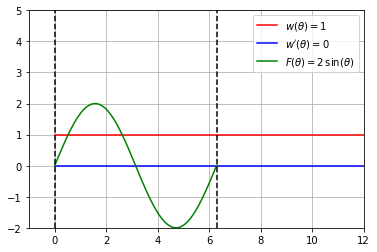

In [113]:
th = np.linspace(0,4*np.pi,200)
thh = np.linspace(0,2*np.pi,100)
W = w(th)
plt.plot(th,w(th),"-r",label=r"$w(\theta) = 1$")
plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = 0$")
plt.plot(thh,F(thh),"-g",label = r"$F(\theta) = 2\,\sin{(\theta)}$")

plt.xlim(-1,12)
plt.ylim(-2,5)

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2*np.pi, color='k', linestyle='--')

plt.grid(True)
plt.legend(loc="best")
plt.show()

In [114]:
def simulation(i,N,M,eps):
    def w(theta):
        return theta**0
    def wp(theta):
        return theta*0

    def F(theta):
        return 2*np.sin(theta)
    
    y1 = explicit_fft_method(w,wp,F,N,M,eps)
    y2 = implicit_method(w,wp,F,N,M,eps)
    
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,2,M)
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y1[:,i],"-yo", label="Explicit Fast Fourier Transform")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(1, 2, 2)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y2[:,i],"-bo", label="Implicit Finite Difference")
    plt.ylim(-5,6)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.show()

In [115]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[2.,1.,0.1,0.01,0.001,0.],value=0, description='eps')
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')
interact(simulation,i=i_widget,N=N_widget,M=M_widget, eps=eps_widget)

<function __main__.simulation>

In this particular case, $\Theta(t) = t$, since $\omega(\theta) = 1$. So, it is necessary to solve the PDE:

$$
\begin{aligned}
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\Theta(\tau-s))} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \frac{1}{\omega^2(\tau-s)} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \frac{1}{1} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{1}{P} \int_{0}^{P} \mathrm{d}\tau \frac{\partial^2A_0}{\partial s^2}\\
\frac{\partial A_0}{\partial T} &= \frac{\partial^2A_0}{\partial s^2}\\
\end{aligned}
$$

That is an usual Diffusion Equation with Difusivity coefficient equal to 1. The initial condition is:

$$
\begin{aligned}
A_0(s,0) &= F(\Theta(-s))\omega(\Theta(-s))\\
&= F(-s)\omega(-s)\\
&= F(-s)\\
&= 2\,\sin{(-s)}\\
&= -2\,\sin{(s)}\\
\end{aligned}
$$

And the variable $s$ has periodic conditions.

The following code solves the Partial Differential Equation
$$
\begin{aligned}
\frac{\partial A_0}{\partial T} &= \frac{\partial^2A_0}{\partial s^2}\\
A_0(s,0)&= -2\,\sin{(s)}\\
\end{aligned}
$$
using an implicit method.

In [19]:
eps = 10**-3
n_s = 10
s = np.linspace(0,2*np.pi,n_s+1)
#print(s)
delta_s = s[1]-s[0]
delta_T = 0.1

sigma = delta_T/(delta_s**0.5)

A = np.diag((1+2*sigma)*np.ones(n_s))+np.diag((-sigma)*np.ones(n_s-1),1)+np.diag((-sigma)*np.ones(n_s-1),-1)
A[-1,0] = -sigma
A[0,-1] = -sigma
#print(A)

sols = np.zeros((n_s,101))
sols[:,0] = -2*np.sin(s[:-1])

for i in range(1,101):
    sols[:,i] = np.linalg.solve(A,sols[:,i-1])


The next function is made in order to use a widget that visualizes the evolution of $A_0(s,T)$ for values of $T$ such that $T \in []$ 

In [20]:
def print_simulation(i):
    x = s[:-1]
    y = sols
    plt.ylim(-3,3)
    plt.grid(True)
    plt.xlabel("$s$")
    plt.ylabel("$A_0(s,T)$")
    plt.title("t = "+str(delta_T*i/eps))
    plt.plot(x,y[:,i],"ro")
    plt.show()
interact(print_simulation,i=(0,100))

<function __main__.print_simulation>

The previous result can be interpretated as a really slow diffusion process, since the slow scale is involved. For big values of $t$ the changes in terms of diffusion will be noticed.

**Numerical Example 2**
Consider the following functions for $\omega(\theta)$ and $F(\theta)$.
\begin{align}
\omega(\theta) &= \sin^2{\left(\frac{\theta}{2}+\frac{1}{2}\right)}\\
\omega'(\theta) &= \frac{1}{2}\sin{(\theta+1)}\\
F(\theta) &= 2\,\sin{(\theta)}
\end{align}

In [189]:
def w(theta):
    #return (np.sin(0.5*theta))**2+0.5
    #return (np.cos(0.5*theta))**2+0.5
    return theta**0
def wp(theta):
    #return 0.5*np.sin(theta)
    #return -2*np.sin(2*theta)
    return theta*0
def F(theta):
    #return (-theta**2+2*np.pi*theta)*0.5
    return 2*np.sin(theta)

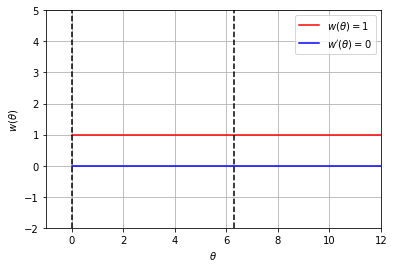

In [191]:
th = np.linspace(0,4*np.pi,200)
thh = np.linspace(0,2*np.pi,100)
W = w(th)
plt.plot(th,w(th),"-r",label=r"$w(\theta) = 1$")
plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = 0$")
#plt.plot(th,w(th),"-r",label=r"$w(\theta) = \cos^2{\left(\frac{\theta}{2}\right)+\frac{1}{2}}$")
#plt.plot(th,wp(th),"-b",label=r"$w'(\theta) = \frac{1}{2}\sin{(\theta)}$")
#plt.plot(thh,F(thh),"-g",label = r"$F(\theta) = 2\,\sin{(\theta)}$")

plt.xlim(-1,12)
plt.ylim(-2,5)

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=2*np.pi, color='k', linestyle='--')

plt.grid(True)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$w(\theta)$")
plt.legend(loc="best")
plt.savefig("omega.pdf")
plt.show()


In [15]:
def simulation2(i,N,M,eps):
    def w(theta):
        return (np.sin(0.5*theta))**2+0.5
        
    def wp(theta):
        return 0.5*np.sin(theta)
        
    def F(theta):
        return 2*np.sin(theta)
    
    y1 = explicit_fft_method(w,wp,F,N,M,eps)
    y2 = implicit_method(w,wp,F,N,M,eps)
    
    Theta = np.linspace(0,2*np.pi,N)
    T = np.linspace(0,2,M)
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y1[:,i],"-yo", label="Explicit Fast Fourier Transform")
    plt.ylim(-5,4)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.subplot(1, 2, 2)
    plt.title("t = "+str(T[i])+" [s]")
    plt.plot(Theta[:],y2[:,i],"-bo", label="Implicit Finite Difference")
    plt.ylim(-5,4)
    plt.grid(True)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$u(\theta,t)$")
    plt.legend(loc="best")
    
    plt.show()

In [16]:
i_widget = IntSlider(min=0, max=79, value=0)
N_widget = IntSlider(min=2, max=200, value=50)
M_widget = IntSlider(min=2, max=400, value=80)
eps_widget = Dropdown(options=[2.,1.,0.1,0.01,0.001,0.],value=0, description='eps')
def update_i_values(*args):
    i_widget.max = M_widget.value-1
M_widget.observe(update_i_values, 'value')
interact(simulation2,i=i_widget,N=N_widget,M=M_widget, eps=eps_widget)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.simulation2>

## References
[] Jupyter Notebooks of SC2. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC2

[1] Jupyter Notebooks of SC5. Claudio Torres. https://github.com/tclaudioe/Scientific-Computing/tree/master/SC5

[2] Using observe to update values in a widget. http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#Arguments-that-are-dependent-on-each-other